# 1. Forward feature selection

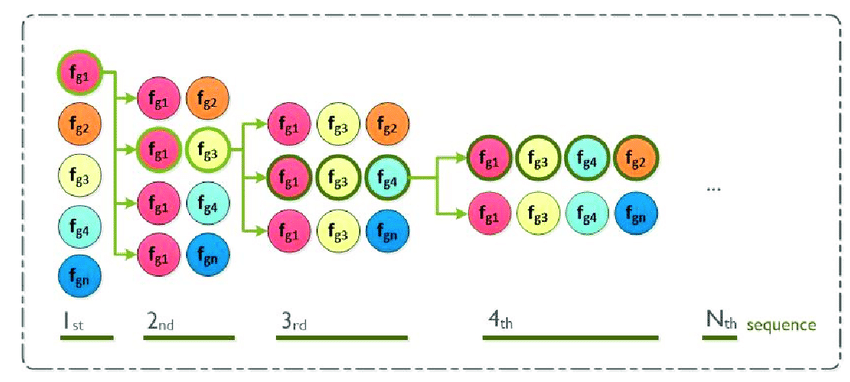

Reducing the number of features we use can have three benefits:

* Simplifies model explanation

* Model fit may be improved by the removal of features that add no value

* Model will be faster to fit

In this notebook we will use a model-based approach whereby we incrementally add features that most increase model performance (we could use simple accuracy, but in this case we will use ROC Area Under Curve as a more thorough analysis of performance).

Two key advantages of this method are:

* It is relatively simple.

*  It is tailored to the model in question.

Some key disadvantage of this method are:

* It may be slow if there are many parameters (though the loop to select features could be limited in the number of features to select).

* The selection of features may be dependent on model meta-parameters (such as level of regularisation).

* The selection of features may not transfer between models (e.g. a model that does not allow for feature interactions may not detect features which do not add much value independently).

We will go through the following steps:

* Download and save pre-processed data

* Split data into features (X) for both accessible features and all features, and label (y)

* Loop through features to select the feature that most increases ROC AUC

* Plot results

https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination

## 1.0. Packages and data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import optuna
from sklearn.metrics import roc_curve, auc
import ml_helper as ml_help
from IPython.display import clear_output
import sys
path = "../../diametrics"
sys.path.append(path)

In [3]:
# Define directory
directory = '../../data/tidy_data/final_df/'

# Read data
df = pd.read_csv(directory + 'df.csv')
strat = df['stratify']
X = pd.read_csv(directory + 'X.csv')
y = df['y']

## 2. Feature selection easily accessible features

In [4]:
# Select readily available features
selected_features = ['start_glc',
                    'duration',
                    'intensity',
                    'form_of_exercise_aer',
                    'form_of_exercise_ana',
                    'form_of_exercise_mix',
                    'years_since_diagnosis',
                    'hba1c',
                    'time_of_day_morning',
                    'time_of_day_afternoon',
                    'time_of_day_evening',
                    'sex_male',
                    'sex_female',
                    'bmi',
                    'age']

X_simple = X[selected_features]

In [6]:
#%%capture

# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X_simple)
run = 0
number_of_features = len(list(X_simple))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X_simple[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        # Use strat column to stratify by both ID and y
        skf.get_n_splits(X_np, strat)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_help.standardise_data(X_train, X_test)
    
            # Set up and fit model
            model = XGBClassifier(eval_metric='logloss')

            # Fit to training data
            model.fit(X_train_std, y_train)
    
            # Predict test set labels
            y_pred_test = model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] 
            
            # Probability of having a hypo
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            #clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

Feature run 1 of 15
Feature run 2 of 15
Feature run 3 of 15
Feature run 4 of 15
Feature run 5 of 15
Feature run 6 of 15
Feature run 7 of 15
Feature run 8 of 15
Feature run 9 of 15
Feature run 10 of 15
Feature run 11 of 15
Feature run 12 of 15
Feature run 13 of 15
Feature run 14 of 15
Feature run 15 of 15


In [7]:
results

,feature to add,ROC AUC
0,start_glc,0.783958
1,duration,0.837345
2,time_of_day_morning,0.844492
3,form_of_exercise_aer,0.847397
4,form_of_exercise_ana,0.848428
5,time_of_day_evening,0.847557
6,sex_male,0.846039
7,time_of_day_afternoon,0.846389
8,sex_female,0.846389
9,form_of_exercise_mix,0.844901


In [31]:
# Save results
results.to_csv('forward_feature_results.csv')

## 1.2. Feature selection of all features

In [15]:
import tune
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = ml_help.standardise_data(X_train, X_test)
    
            # Set up and fit model
            pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: tune.xgb_objective(trial, X_train, y_train), n_trials=100) # , timeout=600
            clear_output()
            best_params = study.best_params
            tuned_model = XGBClassifier(**best_params)
            
            tuned_model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = tuned_model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = tuned_model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] # Probability of 'survived'
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
            
            clear_output()
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

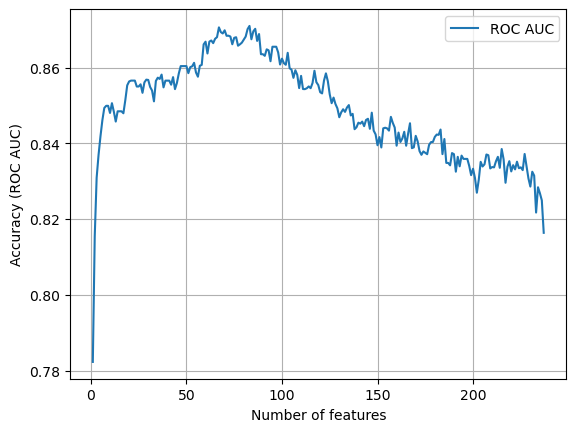

In [32]:
chart_x = list(range(1, number_of_features+1))

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy (ROC AUC)')
plt.legend()
plt.grid(True)

plt.show()

In [35]:
results.sort_values('ROC AUC', ascending=False)

,feature to add,ROC AUC
82,day_of_week_1,0.870981
66,"before_glc__agg_linear_trend__attr_""rvalue""__c...",0.870599
85,before_TIR_hyper,0.870219
81,"before_glc__fft_coefficient__attr_""angle""__coe...",0.870139
69,before_TIR_hyper_exercise,0.869824
...,...,...
235,"before_glc__fft_coefficient__attr_""imag""__coeff_5",0.824947
232,before_glc__energy_ratio_by_chunks__num_segmen...,0.821729
236,"before_glc__change_quantiles__f_agg_""mean""__is...",0.816382
1,duration,0.815426
